In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8caa7b58-22dc-309c-e717-d3504feec1b8)


In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karimcossentini","key":"3f57eca88f2093c1b3633d66fe5d8cc1"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                             title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                             9KB  2022-10-06 08:55:25          12823        408  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset      11KB  2022-09-30 04:05:11          10172        316  1.0              
thedevastator/240000-household-electricity-consumption-records  Household Electricity Consumption            3MB  2022-10-24 01:22:40            842         25  1.0              
akshaydattatraykhare/data-for-admission-in-the-university       Data for Admission in the University     

In [5]:
!kaggle datasets download -d felicepollano/watermarked-not-watermarked-images

100% 697M/698M [00:23<00:00, 33.3MB/s]
100% 698M/698M [00:23<00:00, 30.7MB/s]


In [6]:
! unzip /content/watermarked-not-watermarked-images.zip -d /content



Streaming output truncated to the last 5000 lines.
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3535082.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3535630.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3536072.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3536235.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3536271.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3536293.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3536426.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3536516.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3539894.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3539898.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3544555.jpeg  
  inflating: /content/wm-nowm/valid/no-watermark/pexels-photo-3546189.jpeg  
  inflating: /content/wm-

In [7]:
%matplotlib inline
import cv2
import os
import math
import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torchvision
import random
from os import listdir
from os.path import isfile, join
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
from torch import nn

# import skimage
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.manual_seed(0)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
IMG_SIZE=324
BATCH_SIZE = 8
TRAIN_DATA_PATH = "/content/wm-nowm/train"
TEST_DATA_PATH = "/content/wm-nowm/valid"


transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)



train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transforms_train)
trainloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=transforms_test)
testloader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
print(test_data.class_to_idx)

{'no-watermark': 0, 'watermark': 1}


# **Baseline:** Simple CNN Architecture

In [ ]:
import torch.nn.functional as F

class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(97344, 120)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = ConvNet()

In [ ]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=97344, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

models_dir = "simple_cnn_architecture_models/"
createDirectory(models_dir)

<<__Simple_CNN_Architecture__>>


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 0 , Training Loss: 0.5835214103578032 , Validation Loss: 0.5002566917790371 val_accuracy:  0.7537947783849424


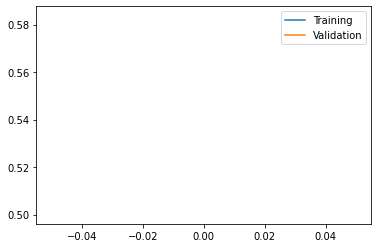

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 1 , Training Loss: 0.4412728471815033 , Validation Loss: 0.4316882896824803 val_accuracy:  0.8084395871281117


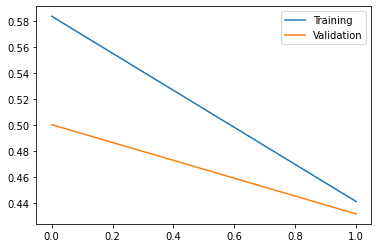

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 2 , Training Loss: 0.35780853548691766 , Validation Loss: 0.43080925685579624 val_accuracy:  0.8154219793564056


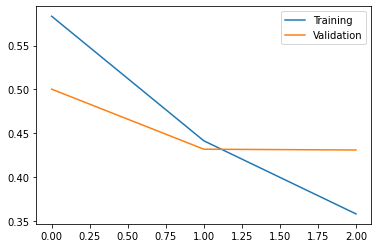

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 3 , Training Loss: 0.263588243754397 , Validation Loss: 0.4706686562564658 val_accuracy:  0.8084395871281117


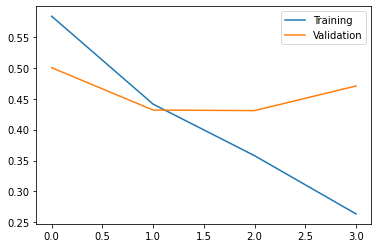

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 4 , Training Loss: 0.1887250118997565 , Validation Loss: 0.6159506528321834 val_accuracy:  0.7770188221007893


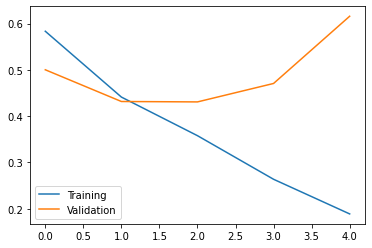

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 5 , Training Loss: 0.1414273571838413 , Validation Loss: 0.718717864910378 val_accuracy:  0.7873406193078324


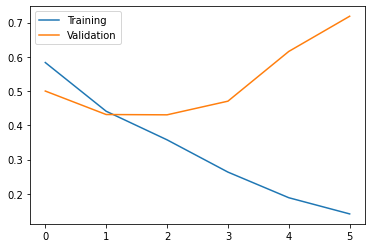

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 6 , Training Loss: 0.12462374008589464 , Validation Loss: 0.7516491420166408 val_accuracy:  0.7976624165148756


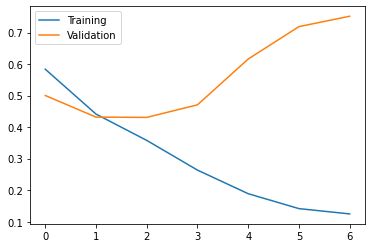

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 7 , Training Loss: 0.1219311490832447 , Validation Loss: 0.7363763608465659 val_accuracy:  0.8028233151183971


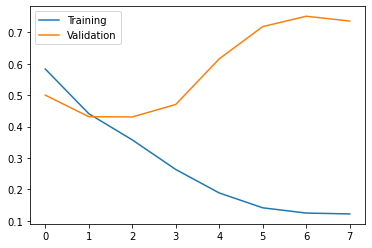

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 8 , Training Loss: 0.0934588151005764 , Validation Loss: 0.9207079435547659 val_accuracy:  0.8040376442015786


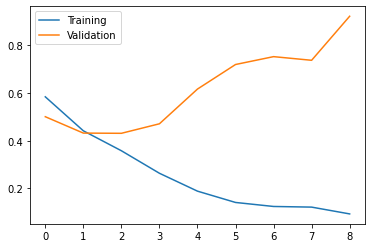

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 9 , Training Loss: 0.07506129299992852 , Validation Loss: 1.1193634775607155 val_accuracy:  0.8040376442015786


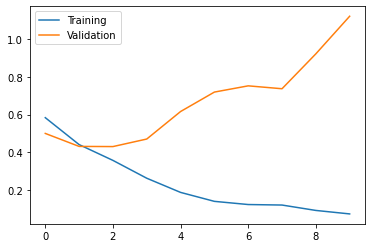

In [ ]:
total_epoch = 10

best_epoch = 0
training_losses = []
val_losses = []
val_acc_list=[]
listplot=[]

print('<<__Simple_CNN_Architecture__>>')
for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    pred=[]
    target=[]
    image_preds_all=[]
    test_labels=[]

    for X, y in trainloader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append((epoch_train_loss/len(trainloader)))
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in testloader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            
            test_labels+=y.cpu()

            image_preds_all += [torch.softmax(result, 1).detach().cpu().numpy()]
        image_preds_all = np.concatenate(image_preds_all, axis=0)
        val_accuracy = np.sum(np.equal(test_labels,np.argmax(image_preds_all, axis=1)))/len(test_labels)

    val_acc_list.append(val_accuracy)      
    val_losses.append(epoch_val_loss/len(testloader))
    
    import numpy as np
    from sklearn.metrics import roc_auc_score

    
    print("EPOCH:", epoch, ", Training Loss:", (epoch_train_loss/len(trainloader)), ", Validation Loss:", (epoch_val_loss/len(testloader)), "val_accuracy: ", val_accuracy)

    listplot.append(epoch)
    plt.plot(listplot, training_losses, label='Training')
    plt.plot(listplot, val_losses, label='Validation')
    plt.legend()
    plt.show()

    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + 'simple_cnn_epoch_{}.pth'.format(epoch))
        print("Model saved")


**Confusion matrix: simple cnn architecture**

In [ ]:
models_dir = "simple_cnn_architecture_models/"

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + 'simple_cnn_epoch_' + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

In [ ]:
y_true=[]
image_preds_all=[]
for X, y in testloader:
    
    X, y = X.cuda(), y.cuda()
      
    result = loaded_model(X)
    loss = criterion(result, y)
    epoch_val_loss += loss.item()
    
    y_true+=y.cpu()

    image_preds_all += [torch.softmax(result, 1).detach().cpu().numpy()]
image_preds_all = np.concatenate(image_preds_all, axis=0)
y_pred = np.argmax(image_preds_all, axis=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Text(0, 0.5, 'Actual'),
 Text(0.5, 0, 'Predicted'),
 Text(0.5, 1.0, 'Confusion Matrix for no/watermarked images')]

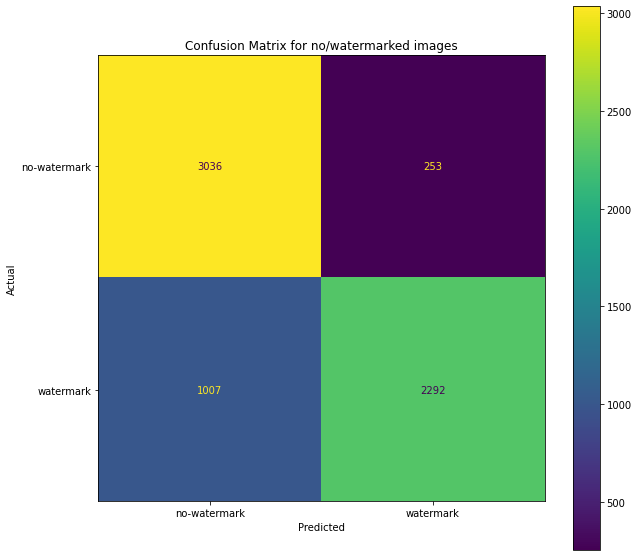

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

cmd_obj = ConfusionMatrixDisplay(conf_matrix, display_labels=['no-watermark', 'watermark'])
fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(
                title='Confusion Matrix for no/watermarked images', 
                xlabel='Predicted', 
                ylabel='Actual'
                )

# **Resnet50**

In [ ]:
model = models.resnet50(pretrained=True)

fc_inputs = model.fc.in_features
 
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(fc_inputs, 2),
)

In [ ]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

models_dir = "resnet50_models/"
createDirectory(models_dir)

Directory resnet50_models/ already exists.


<<__Resnet50__>>


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 0 , Training Loss: 0.48472306781261204 , Validation Loss: 0.3612906645838786 val_accuracy:  0.8629326047358834


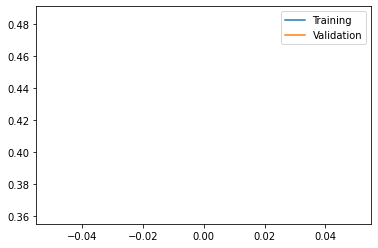

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 1 , Training Loss: 0.32934036606233497 , Validation Loss: 0.28112153382067684 val_accuracy:  0.8884335154826958


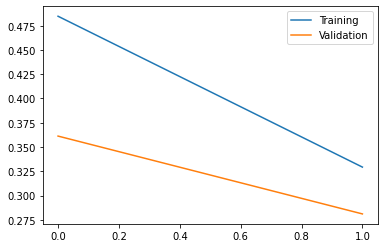

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 2 , Training Loss: 0.287749464193743 , Validation Loss: 0.3057294188799716 val_accuracy:  0.8778081360048573


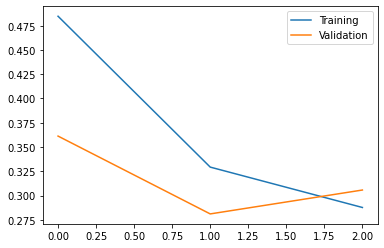

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 3 , Training Loss: 0.25150974830654277 , Validation Loss: 0.2503258191067183 val_accuracy:  0.906648451730419


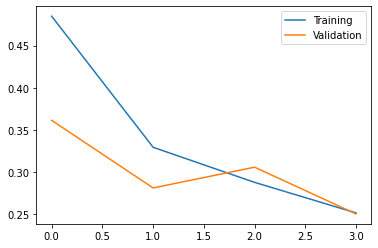

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 4 , Training Loss: 0.24246502598114408 , Validation Loss: 0.25469745979734776 val_accuracy:  0.9005768063145112


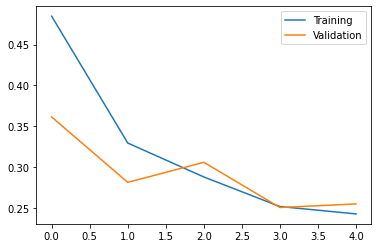

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 5 , Training Loss: 0.21104608990058837 , Validation Loss: 0.22458510791647782 val_accuracy:  0.9231936854887675


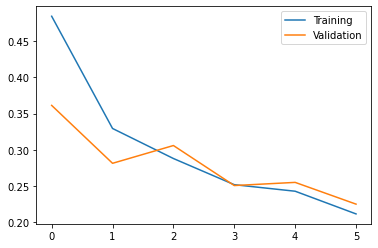

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 6 , Training Loss: 0.20583228603638612 , Validation Loss: 0.17214278161618407 val_accuracy:  0.9374620522161505


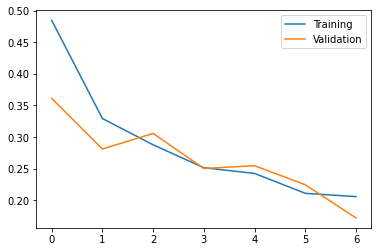

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 7 , Training Loss: 0.1932801548398661 , Validation Loss: 0.1723179134207685 val_accuracy:  0.9423193685488768


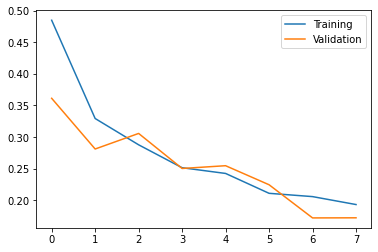

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 8 , Training Loss: 0.17894343767059065 , Validation Loss: 0.18539430863434195 val_accuracy:  0.9374620522161505


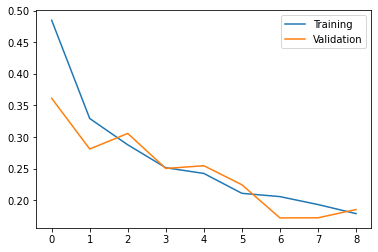

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 9 , Training Loss: 0.1811146384942837 , Validation Loss: 0.16466751411044067 val_accuracy:  0.9426229508196722


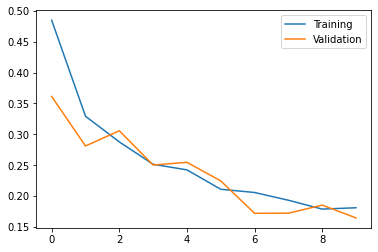

Model saved


In [ ]:
total_epoch = 10

best_epoch = 0
training_losses = []
val_losses = []
val_acc_list=[]
listplot=[]

print('<<__Resnet50__>>')

for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    pred=[]
    target=[]
    image_preds_all=[]
    test_labels=[]

    for X, y in trainloader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append((epoch_train_loss/len(trainloader)))
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in testloader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            
            test_labels+=y.cpu()

            image_preds_all += [torch.softmax(result, 1).detach().cpu().numpy()]
        image_preds_all = np.concatenate(image_preds_all, axis=0)
        val_accuracy = np.sum(np.equal(test_labels,np.argmax(image_preds_all, axis=1)))/len(test_labels)

    val_acc_list.append(val_accuracy)      
    val_losses.append(epoch_val_loss/len(testloader))
    
    import numpy as np
    from sklearn.metrics import roc_auc_score

    
    #accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", (epoch_train_loss/len(trainloader)), ", Validation Loss:", (epoch_val_loss/len(testloader)), "val_accuracy: ", val_accuracy)

    listplot.append(epoch)
    plt.plot(listplot, training_losses, label='Training')
    plt.plot(listplot, val_losses, label='Validation')
    plt.legend()
    plt.show()

    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + 'resnet50_epoch_{}.pth'.format(epoch))
        print("Model saved")

**Confusion matrix: resnet50**

In [ ]:
models_dir = "resnet50_models/"

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + 'resnet50_epoch_' + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

In [ ]:
y_true=[]
image_preds_all=[]
for X, y in testloader:
    
    X, y = X.cuda(), y.cuda()
      
    result = loaded_model(X)
    loss = criterion(result, y)
    epoch_val_loss += loss.item()
    
    y_true+=y.cpu()

    image_preds_all += [torch.softmax(result, 1).detach().cpu().numpy()]
image_preds_all = np.concatenate(image_preds_all, axis=0)
y_pred = np.argmax(image_preds_all, axis=1)

[Text(0, 0.5, 'Actual'),
 Text(0.5, 0, 'Predicted'),
 Text(0.5, 1.0, 'Confusion Matrix for no/watermarked images')]

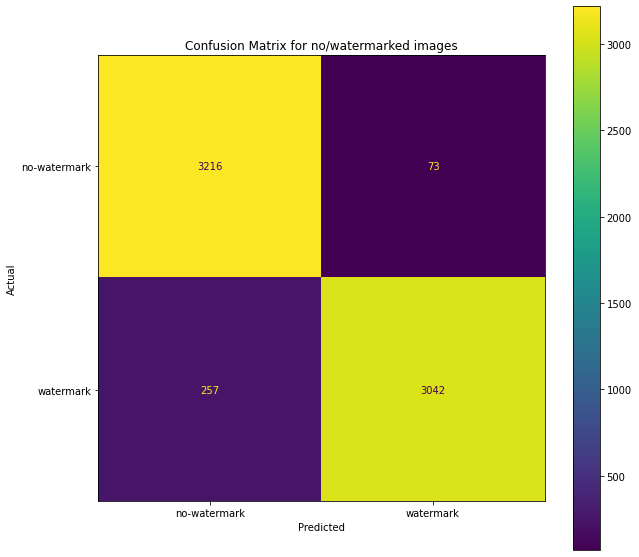

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

cmd_obj = ConfusionMatrixDisplay(conf_matrix, display_labels=['no-watermark', 'watermark'])
fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(
                title='Confusion Matrix for no/watermarked images', 
                xlabel='Predicted', 
                ylabel='Actual'
                )

# **Efficient Net**

In [14]:
model = models.efficientnet_b3(pretrained=True)

fc_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(fc_inputs, 2),
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

In [15]:
LEARNING_RATE = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [11]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

models_dir = "efficientnet_b3_models/"
createDirectory(models_dir)

<<__EfficientNetb3__>>


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 0 , Training Loss: 0.20963928044564806 , Validation Loss: 0.12930539245739833 val_accuracy:  0.9552216150576807


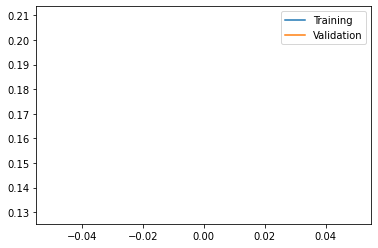

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 1 , Training Loss: 0.12315961930167589 , Validation Loss: 0.07104615089889035 val_accuracy:  0.9734365513054037


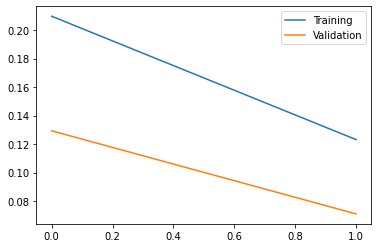

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 2 , Training Loss: 0.09121061098935529 , Validation Loss: 0.075361669498077 val_accuracy:  0.9726775956284153


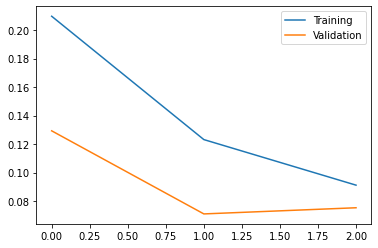

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 3 , Training Loss: 0.07533571478709207 , Validation Loss: 0.08146009149662224 val_accuracy:  0.9710078931390407


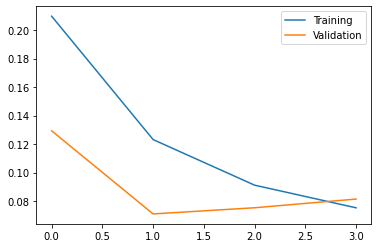

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 4 , Training Loss: 0.06073776160024356 , Validation Loss: 0.06600074195884835 val_accuracy:  0.9744990892531876


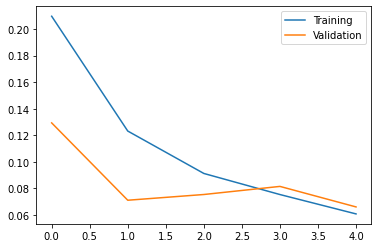

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 5 , Training Loss: 0.05710634629496333 , Validation Loss: 0.058052307601084395 val_accuracy:  0.9785974499089253


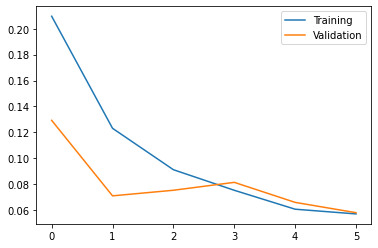

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 6 , Training Loss: 0.04959848011284662 , Validation Loss: 0.06104931347221882 val_accuracy:  0.978749241044323


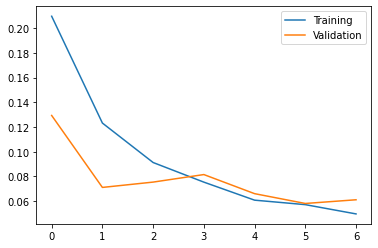

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 7 , Training Loss: 0.04752535475318766 , Validation Loss: 0.07668288637783405 val_accuracy:  0.9773831208257437


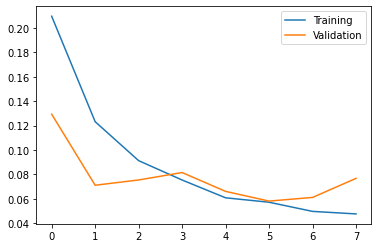

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 8 , Training Loss: 0.04007712361755499 , Validation Loss: 0.05307989558784878 val_accuracy:  0.9799635701275046


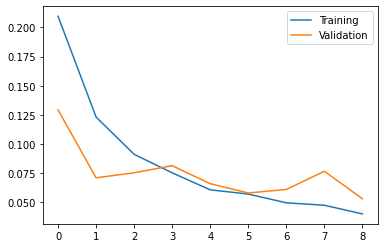

Model saved


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


EPOCH: 9 , Training Loss: 0.038438811890886694 , Validation Loss: 0.04901677223081173 val_accuracy:  0.9833029751062538


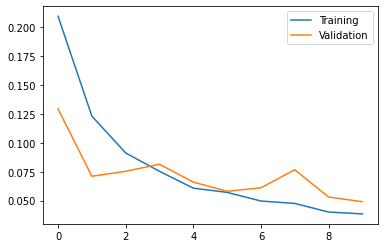

Model saved


In [16]:
total_epoch = 10

best_epoch = 0
training_losses = []
val_losses = []
val_acc_list=[]
listplot=[]

print('<<__EfficientNetb3__>>')

for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    pred=[]
    target=[]
    image_preds_all=[]
    test_labels=[]

    for X, y in trainloader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append((epoch_train_loss/len(trainloader)))
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in testloader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            
            test_labels+=y.cpu()

            image_preds_all += [torch.softmax(result, 1).detach().cpu().numpy()]
        image_preds_all = np.concatenate(image_preds_all, axis=0)
        val_accuracy = np.sum(np.equal(test_labels,np.argmax(image_preds_all, axis=1)))/len(test_labels)

    val_acc_list.append(val_accuracy)       
    val_losses.append(epoch_val_loss/len(testloader))
    
    import numpy as np
    from sklearn.metrics import roc_auc_score

    
    print("EPOCH:", epoch, ", Training Loss:", (epoch_train_loss/len(trainloader)), ", Validation Loss:", (epoch_val_loss/len(testloader)), "val_accuracy: ", val_accuracy)

    listplot.append(epoch)
    plt.plot(listplot, training_losses, label='Training')
    plt.plot(listplot, val_losses, label='Validation')
    plt.legend()
    plt.show()

    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + 'efficientnet_b3_epoch_{}.pth'.format(epoch))
        print("Model saved")

**Confusion matrix : Efficientnet_b3**

In [17]:
models_dir = "efficientnet_b3_models/"

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + 'efficientnet_b3_epoch_' + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

In [20]:
y_true=[]
image_preds_all=[]
for X, y in testloader:
    
    X, y = X.cuda(), y.cuda()
      
    result = loaded_model(X)
    loss = criterion(result, y)
    epoch_val_loss += loss.item()
    
    y_true+=y.cpu()

    image_preds_all += [torch.softmax(result, 1).detach().cpu().numpy()]
image_preds_all = np.concatenate(image_preds_all, axis=0)
y_pred = np.argmax(image_preds_all, axis=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Text(0, 0.5, 'Actual'),
 Text(0.5, 0, 'Predicted'),
 Text(0.5, 1.0, 'Confusion Matrix for no/watermarked images')]

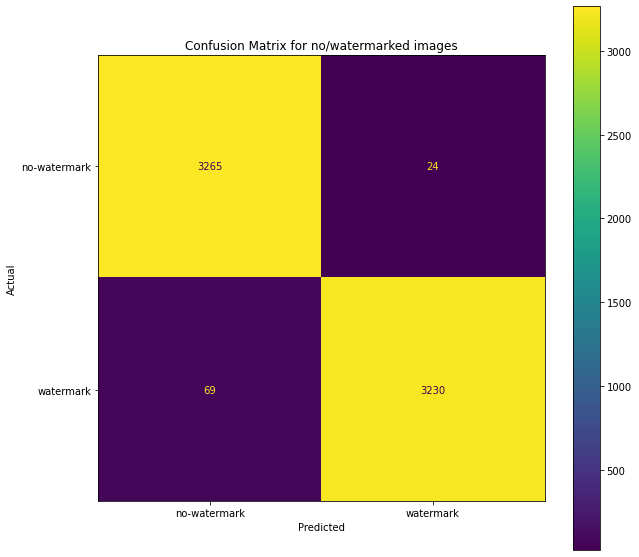

In [21]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

cmd_obj = ConfusionMatrixDisplay(conf_matrix, display_labels=['no-watermark', 'watermark'])
fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(
                title='Confusion Matrix for no/watermarked images', 
                xlabel='Predicted', 
                ylabel='Actual'
                )